# Loading Data Sets

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


# torch needed for esm transformers
import torch
import esm

In [2]:
def scan_directory(directory_path, file_extension=".xlsx"):
    data_files = []
    try:
        directory = Path(directory_path)
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith(file_extension):
                    file_path = Path(root) / file
                    relative_path = str(file_path.relative_to(directory))
                    data_files.append(relative_path)

        return data_files
    except Exception as e:
        print("❌ Error scanning directory: {e}")
        return []


In [3]:
def read_files(files_list):
    dfs = []
    for file in files_list:
        df = pd.read_excel(file)
        dfs.append(df)

    return dfs

# Data Cleanup and Feature Engineering

In [4]:
def create_clean_df(list_of_dfs):
    merged_df = list_of_dfs[0]
    for i in range(1, len(list_of_dfs)):
        merged_df = pd.merge(merged_df, list_of_dfs[i], on="Name", how="inner")

    merged_df = merged_df.dropna(axis=1, how="all")

    return merged_df

In [5]:
# Kyte-Doolitle (GRAVY) table
KD = {
    "A": 1.8,
    "R": -4.5,
    "N": -3.5,
    "D": -3.5,
    "C": 2.5,
    "Q": -3.5,
    "E": -3.5,
    "G": -0.4,
    "H": -3.2,
    "I": 4.5,
    "L": 3.8,
    "K": -3.9,
    "M": 1.9,
    "F": 2.8,
    "P": -1.6,
    "S": -0.8,
    "T": -0.7,
    "W": -0.9,
    "Y": -1.3,
    "V": 4.2,
}

HYDROPHOBIC = set("AILMVFWYV")
AROMATIC = set("FWY")
POSITIVE = set("KRH")
NEGATIVE = set("DE")
POLAR = set("STNQ")

In [6]:
def aa_counts(seq):
    counts = {aa: 0 for aa in KD.keys()}
    if isinstance(seq, str):
        for ch in seq.upper():
            if ch in counts:
                counts[ch] += 1

    return counts

In [7]:
def seq_features(seq, prefix):
    counts = aa_counts(seq)
    L = sum(counts.values())
    feats = {f"{prefix}_len": float(L)}

    if L == 0:
        for k in [
            "hydrophobic_frac",
            "aromatic_frac",
            "positive_frac",
            "negative_frac",
            "polar_frac",
            "kd_gravy",
        ]:
            feats[f"{prefix}_{k}"] = 0.0
        for aa in KD.keys():
            feats[f"{prefix}_comp_{aa}"] = 0.0

        return feats

    feats[f"{prefix}_hydrophobic_frac"] = (
        sum(counts[a] for a in HYDROPHOBIC if a in counts) / L
    )
    feats[f"{prefix}_aromatic_frac"] = (
        sum(counts[a] for a in AROMATIC if a in counts) / L
    )
    feats[f"{prefix}_positive_frac"] = (
        sum(counts[a] for a in POSITIVE if a in counts) / L
    )
    feats[f"{prefix}_negative_frac"] = (
        sum(counts[a] for a in NEGATIVE if a in counts) / L
    )
    feats[f"{prefix}_polar_frac"] = sum(counts[a] for a in POLAR if a in counts) / L
    feats[f"{prefix}_kd_gravy"] = sum(KD[a] * counts[a] for a in KD.keys()) / L

    for aa in KD.keys():
        feats[f"{prefix}_comp_{aa}"] = counts[aa] / L

    return feats


In [8]:
def engineer_sequence_features(df, seq_cols=("VH", "VL")):
    rows = []
    for _, row in df.iterrows():
        feats = {}
        for col in seq_cols:
            feats.update(seq_features(row.get(col, None), col))
        rows.append(feats)
    feat_df = pd.DataFrame(rows, index=df.index)
    return feat_df

In [9]:
def embed_sequence_esm2(seq, model, alphabet, device="cpu"):
    if not isinstance(seq, str) or len(seq.strip()) == 0:
        return np.zeros(model.embed_dim, dtype=np.float32)

    batch_converter = alphabet.get_batch_converter()
    data = [("seq1", seq)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_tokens = batch_tokens.to(device)

    with torch.no_grad():
        layer = model.num_layers
        results = model(batch_tokens, repr_layers=[layer], return_contacts=False)
        token_representations = results["representations"][layer]

    embedding = token_representations[0, 1:-1].mean(0).cpu().numpy().astype(np.float32)
    return embedding

In [10]:
# Load model once

def load_esm2_model(model_name="esm2_t6_8M_UR50D", device=None):
    if device is None:
        device = "mps" if torch.backends.mps.is_available() else "cpu"

    model, alphabet = esm.pretrained.load_model_and_alphabet(model_name)
    model = model.eval().to(device)
    print(f"Loaded {model_name} on device: {device.upper()}")
    return model, alphabet, device

In [11]:
def build_model_ready_from_merged(
    merged_df,
    target_col="Slope for Accelerated Stability",
    seq_cols=("VH", "VL"),
    include_assays=False,
    impute_strategy="median",
    include_esm=True,
    esm_model_name="esm2_t6_8M_UR50D"
):
    if target_col in merged_df.columns:
        df = merged_df.dropna(subset=[target_col]).copy()
    else:
        df = merged_df.copy()

    # Classic engineered features
    seq_feats = engineer_sequence_features(df, seq_cols=seq_cols)

    if include_assays:
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if target_col in num_cols:
            num_cols.remove(target_col)
        assay_feats = df[num_cols].copy()
    else:
        assay_feats = pd.DataFrame(index=df.index)

    X_raw = pd.concat([seq_feats, assay_feats], axis=1)
    feature_columns = X_raw.columns.tolist()
    y = df[target_col].values if target_col in df.columns else None

    imputer = SimpleImputer(strategy=impute_strategy)
    scaler = StandardScaler()
    X_imputed = imputer.fit_transform(X_raw)
    X_scaled = scaler.fit_transform(X_imputed)
    X = pd.DataFrame(X_scaled, index=df.index, columns=feature_columns)

    # ESM-2 embeddings integration
    esm_X, esm_y = None, None
    if include_esm:
        print("🔷 Loading ESM-2 Model...")
        model, alphabet, device = load_esm2_model(esm_model_name)

        esm_embeddings = []
        for _, row in df.iterrows():
            vh_seq, vl_seq = row.get("VH", ""), row.get("VL", "")
            vh_emb = embed_sequence_esm2(vh_seq, model, alphabet, device)
            vl_emb = embed_sequence_esm2(vl_seq, model, alphabet, device)
            combined_emb = np.concatenate([vh_emb, vl_emb])
            esm_embeddings.append(combined_emb)

        esm_X = np.vstack(esm_embeddings)
        esm_y = y.copy() if y is not None else None

    return {
        "X": X,
        "y": y,
        "esm_X": esm_X,
        "esm_y": esm_y,
        "feature_columns": feature_columns,
        "supervised_df": df,
        "imputer": imputer,
        "scaler": scaler
    }

In [12]:
# Combined EDA test cell

directory = os.getcwd()
data_files = scan_directory(directory, file_extension=".xlsx")
print("Files found:", data_files)

dfs = read_files(data_files)
print("Number of dataframes:", len(dfs))

merged_df = create_clean_df(dfs)
print("Merged dataframe shape:", merged_df.shape)

model_ready_df = build_model_ready_from_merged(
    merged_df,
    target_col="Slope for Accelerated Stability",
    include_assays=False,
    include_esm=True,
    esm_model_name="esm2_t6_8M_UR50D"
)

classical_X = model_ready_df["X"]
classical_y = model_ready_df["y"]

esm_X = model_ready_df["esm_X"]
esm_y = model_ready_df["esm_y"]

print("ESM embedding shape:", esm_X.shape)

Files found: ['data/pnas.1616408114.sd02.xlsx', 'data/pnas.1616408114.sd03.xlsx', 'data/pnas.1616408114.sd01.xlsx']
Number of dataframes: 3
Merged dataframe shape: (137, 27)
🔷 Loading ESM-2 Model...
Loaded esm2_t6_8M_UR50D on device: MPS
ESM embedding shape: (137, 640)


In [13]:
from sklearn.metrics import root_mean_squared_error, r2_score

In [14]:
# Mengayo's Original Code

# ----------  MODEL TRAIN / EVAL  ----------
def train_and_eval_return(X, y, model_name):
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.neural_network import MLPRegressor
    from sklearn.svm import SVR

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=41
    )

    if model_name == "rf":
        model = GridSearchCV(
            RandomForestRegressor(random_state=42),
            param_grid={"n_estimators":[10, 50, 200],
                        "max_depth":[None,20,40]},
            n_jobs=-1,
            scoring="neg_root_mean_squared_error"
        )
    elif model_name == "gb":
        model = GridSearchCV(
            GradientBoostingRegressor(random_state=42),
            param_grid={"n_estimators":[10, 50, 200],
                        "learning_rate":[0.05,0.1],
                        "max_depth":[1,3,5]},
            n_jobs=-1,
            scoring="neg_root_mean_squared_error"
        )
    elif model_name == "mlp":
        model = GridSearchCV(
            MLPRegressor(max_iter=500, random_state=42),
            param_grid={"hidden_layer_sizes":[(64,32), (128,64),(256,128)],
                        "alpha":[1e-2, 0.1]},
            n_jobs=-1,
            scoring="neg_root_mean_squared_error"
        )
    elif model_name == "svr":
        model = GridSearchCV(
            SVR(kernel="rbf"),
            param_grid={"C":[1.0,10.0,100.0],
                        "gamma":["scale","auto",0.1]},
            n_jobs=-1,
            scoring="neg_root_mean_squared_error"
        )
    else:
        raise ValueError("Choose model_name from: rf, gb, mlp, svr")

    # Adjusted final calls for numerical comparisons

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    rmse_test  = root_mean_squared_error(y_test, y_test_pred)
    r2_train   = r2_score(y_train, y_train_pred)
    r2_test    = r2_score(y_test, y_test_pred)

    return {
        "model": model_name.upper(),
        "rmse_train": rmse_train,
        "r2_train": r2_train,
        "rmse_test": rmse_test,
        "r2_test": r2_test,
        "best_params": model.best_params_
    }

In [15]:
results = []
for m in ["rf", "gb", "mlp", "svr"]:
    print(f"\n=== {m.upper()} ===")

    classical_res = train_and_eval_return(classical_X.values, classical_y, m)
    classical_res["feature_set"] = "Classical"

    esm_res = train_and_eval_return(esm_X, esm_y, m)
    esm_res["feature_set"] = "ESM-2"

    results.extend([classical_res, esm_res])

results_df = pd.DataFrame(results)
results_df = results_df[[
    "feature_set", "model", "rmse_train", "rmse_test", "r2_train", "r2_test"
]]

results_df


=== RF ===

=== GB ===

=== MLP ===

=== SVR ===


,feature_set,model,rmse_train,rmse_test,r2_train,r2_test
0,Classical,RF,0.064651,0.067881,0.745244,-0.600079
1,ESM-2,RF,0.045499,0.065281,0.873824,-0.479885
2,Classical,GB,0.108646,0.060469,0.280553,-0.269734
3,ESM-2,GB,0.081710,0.055629,0.593069,-0.074623
4,Classical,MLP,0.004429,0.140382,0.998804,-5.843460
5,ESM-2,MLP,0.113308,0.076243,0.217487,-1.018602
6,Classical,SVR,0.086434,0.097069,0.544657,-2.271960
7,ESM-2,SVR,0.132827,0.063517,-0.075335,-0.400993


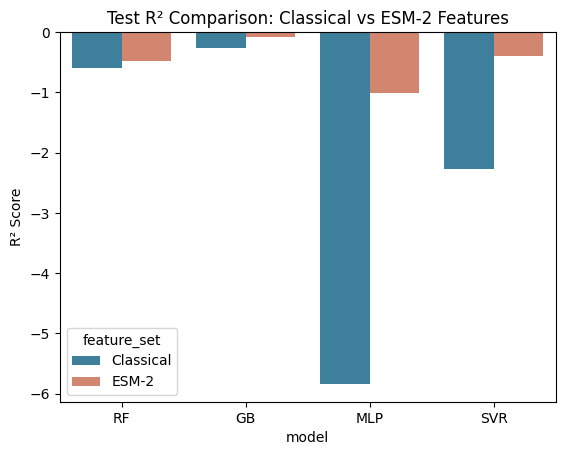

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    data=results_df,
    x="model", y="r2_test", hue="feature_set",
    palette=["#2E86AB", "#E27D60"]
)
plt.title("Test R² Comparison: Classical vs ESM-2 Features")
plt.ylabel("R² Score")
plt.show()

In [17]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

rng = 42
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=rng)

def train_and_eval_proofread(X, y, model_name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rng
    )

    if model_name == "rf":
        est = RandomForestRegressor(random_state=rng, n_jobs=-1)
        grid = {
            "n_estimators": [100, 200],
            "max_depth": [8, 12, 16],
            "min_samples_leaf": [2, 4, 8]
        }

    elif model_name == "gb":
        est = GradientBoostingRegressor(random_state=rng)
        grid = {
            "n_estimators": [100, 200],
            "learning_rate": [0.05, 0.1],
            "max_depth": [2, 3],
            "min_samples_leaf": [2, 4, 8],
            "subsample": [0.7, 1.0]
        }
    
    elif model_name == "mlp":
        est = MLPRegressor(
            hidden_layer_sizes=(128, 64),
            max_iter=1000,
            early_stopping=True,
            validation_fraction=0.15,
            random_state=rng
        )
        grid = {"alpha": [1e-3, 1e-2]}

    elif model_name == "svr":
        est = SVR(kernel="rbf")
        grid = {
            "C": [1.0, 10.0, 50.0],
            "gamma": ["scale", 0.001, 0.1]
        }
    else:
        raise ValueError("rf | gb | mlp | svr")
    
    gs = GridSearchCV(
        est, grid, cv=cv, n_jobs=-1,
        scoring="neg_root_mean_squared_error", refit=True
    )
    gs.fit(X_train, y_train)

    y_train_pred = gs.predict(X_train)
    y_test_pred = gs.predict(X_test)

    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    return {
        "model": model_name.upper(),
        "cv_rmse": -gs.best_score_,
        "train_rmse": rmse_train,
        "test_rmse": rmse_test,
        "train_r2": r2_train,
        "test_r2": r2_test,
        "train_mae": mae_train,
        "test_mae": mae_test,
        "best_params": gs.best_params_,
        "y_train": y_train,
        "y_test": y_test,
        "y_train_pred": y_train_pred,
        "y_test_pred": y_test_pred
    }

In [18]:
results2 = []

for m in ["rf", "gb", "mlp", "svr"]:
    print(f"\n=== {m.upper()} ===")

    classical_res = train_and_eval_proofread(classical_X.values, classical_y, m)
    classical_res["feature_set"] = "Classical"

    esm_res = train_and_eval_proofread(esm_X, esm_y, m)
    esm_res["feature_set"] = "ESM-2"

    results2.extend([classical_res, esm_res]) 

results_df2 = pd.DataFrame(results2)

results_df2 = results_df2.rename(columns={
    "train_rmse": "rmse_train",
    "test_rmse": "rmse_test",
    "train_r2": "r2_train",
    "test_r2": "r2_test"
})[["feature_set", "model", "rmse_train", "rmse_test", "r2_train", "r2_test"]]

results_df2


=== RF ===

=== GB ===

=== MLP ===

=== SVR ===


,feature_set,model,rmse_train,rmse_test,r2_train,r2_test
0,Classical,RF,0.025247,0.234940,0.787111,-0.015690
1,ESM-2,RF,0.023203,0.230074,0.820182,0.025947
2,Classical,GB,0.020572,0.228291,0.858655,0.040989
3,ESM-2,GB,0.014857,0.229768,0.926274,0.028544
4,Classical,MLP,0.142009,0.333694,-5.735528,-1.049006
5,ESM-2,MLP,0.054021,0.231715,0.025295,0.012005
6,Classical,SVR,0.066164,0.227351,-0.462148,0.048874
7,ESM-2,SVR,0.062626,0.223693,-0.309924,0.079229


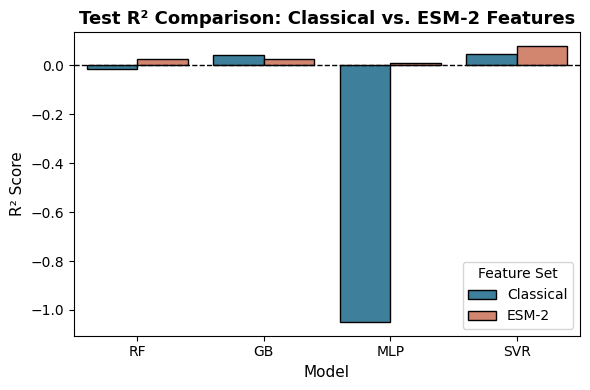

In [19]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=results_df2,
    x="model", y="r2_test", hue="feature_set",
    palette=["#2E86AB", "#E27D60"],
    edgecolor="black"
)

plt.title("Test R² Comparison: Classical vs. ESM-2 Features", fontsize=13, weight="bold")
plt.ylabel("R² Score", fontsize=11)
plt.xlabel("Model", fontsize=11)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.legend(title="Feature Set", loc="lower right", frameon=True)
plt.tight_layout()
plt.show()

In [20]:
results_df["version"] = "original"
results_df2["version"] = "proofread"

combined_df = pd.concat([results_df, results_df2], ignore_index=True)

print("\nCombined Results Comparison (Original vs Reviewed):")
combined_df


Combined Results Comparison (Original vs Reviewed):


,feature_set,model,rmse_train,rmse_test,r2_train,r2_test,version
0,Classical,RF,0.064651,0.067881,0.745244,-0.600079,original
1,ESM-2,RF,0.045499,0.065281,0.873824,-0.479885,original
2,Classical,GB,0.108646,0.060469,0.280553,-0.269734,original
3,ESM-2,GB,0.081710,0.055629,0.593069,-0.074623,original
4,Classical,MLP,0.004429,0.140382,0.998804,-5.843460,original
5,ESM-2,MLP,0.113308,0.076243,0.217487,-1.018602,original
6,Classical,SVR,0.086434,0.097069,0.544657,-2.271960,original
7,ESM-2,SVR,0.132827,0.063517,-0.075335,-0.400993,original
8,Classical,RF,0.025247,0.234940,0.787111,-0.015690,proofread
9,ESM-2,RF,0.023203,0.230074,0.820182,0.025947,proofread


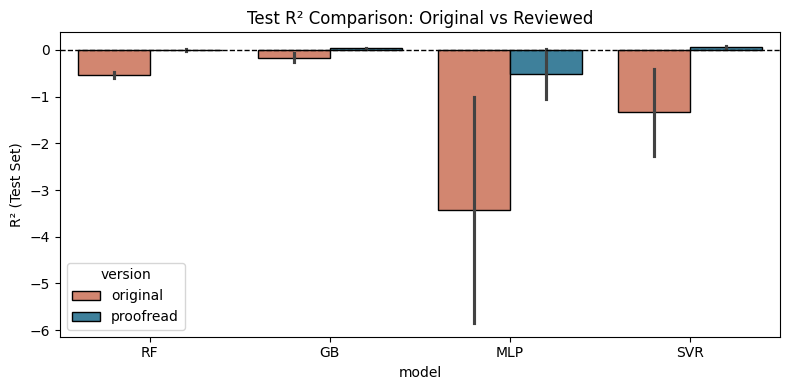

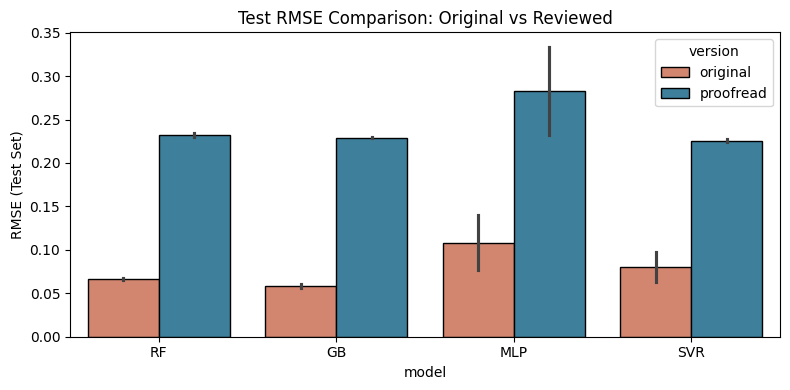

In [21]:

plt.figure(figsize=(8, 4))
sns.barplot(
    data=combined_df,
    x="model", y="r2_test", hue="version",
    palette=["#E27D60", "#2E86AB"],
    edgecolor="black"
)
plt.title("Test R² Comparison: Original vs Reviewed")
plt.ylabel("R² (Test Set)")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(
    data=combined_df,
    x="model", y="rmse_test", hue="version",
    palette=["#E27D60", "#2E86AB"],
    edgecolor="black"
)
plt.title("Test RMSE Comparison: Original vs Reviewed")
plt.ylabel("RMSE (Test Set)")
plt.tight_layout()
plt.show()